# 03. PyTorch Neural Network Classification

## 1. Make classification data and get it ready

In [1]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

X, y = make_circles(n_samples, 
                noise=0.03,
                random_state=42) 

In [2]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [3]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2" : X[:, 1],
                        "label" : y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
# Check different labels
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

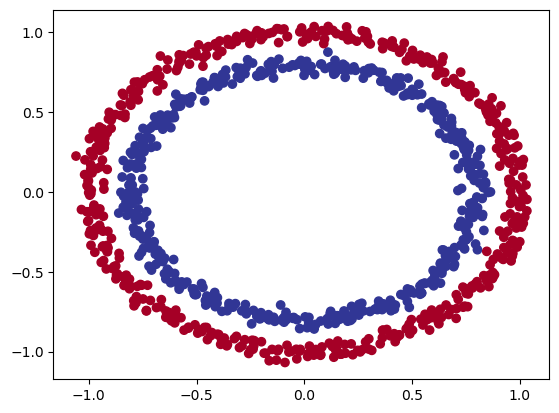

In [5]:
import matplotlib.pyplot as plt
plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c = y,
            cmap = plt.cm.RdYlBu);

### 1.1 Input and output shapes

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [8]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

In [10]:
# standard pytorch imports
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [11]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))
    
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [12]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[1.4895],
        [1.5643],
        [1.0867],
        [1.6045],
        [0.7574],
        [0.8053],
        [1.2764],
        [1.0981],
        [1.1012],
        [1.5656]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer


In [14]:
# Create a loss function
# loss_fn = nn.BCELoss()
loss_fn = nn.BCEWithLogitsLoss()

# create optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.1)

In [15]:
# calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

## 3. Train model

### 3.1 Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)

In [16]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[1.4895],
        [1.5643],
        [1.0867],
        [1.6045],
        [0.7574]], device='cuda:0', grad_fn=<SliceBackward0>)

In [17]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.8160],
        [0.8270],
        [0.7478],
        [0.8326],
        [0.6808]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [18]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds, y_pred_labels))

# Get rid of extra dimension
y_preds.squeeze()

tensor([[True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [19]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building a training and testing loop

In [20]:
torch.manual_seed(42)

# set the number of epochs
epochs = 100

# put data to device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits,
                  y_train)

    acc = accuracy_fn(y_true=y_train,
                     y_pred = y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    # testing
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,
                           y_test)
        test_acc = accuracy_fn(y_true = y_test,
                              y_pred = test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.85137, Accuracy: 50.00% | Test loss: 0.84855, Test acc: 50.00%
Epoch: 10 | Loss: 0.73678, Accuracy: 50.00% | Test loss: 0.73872, Test acc: 50.00%
Epoch: 20 | Loss: 0.70682, Accuracy: 50.00% | Test loss: 0.70844, Test acc: 50.00%
Epoch: 30 | Loss: 0.69830, Accuracy: 58.63% | Test loss: 0.69921, Test acc: 56.50%
Epoch: 40 | Loss: 0.69568, Accuracy: 52.38% | Test loss: 0.69614, Test acc: 54.50%
Epoch: 50 | Loss: 0.69478, Accuracy: 50.88% | Test loss: 0.69501, Test acc: 55.00%
Epoch: 60 | Loss: 0.69440, Accuracy: 49.62% | Test loss: 0.69455, Test acc: 53.50%
Epoch: 70 | Loss: 0.69419, Accuracy: 49.88% | Test loss: 0.69435, Test acc: 54.00%
Epoch: 80 | Loss: 0.69405, Accuracy: 49.25% | Test loss: 0.69425, Test acc: 54.00%
Epoch: 90 | Loss: 0.69393, Accuracy: 49.25% | Test loss: 0.69420, Test acc: 54.50%


## 4. Make predictions and evaluate the model

In [21]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading the helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", 'wb') as f:
        f.write(request.content)

helper_functions.py already exists, skipping download


In [22]:
import numpy as np

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

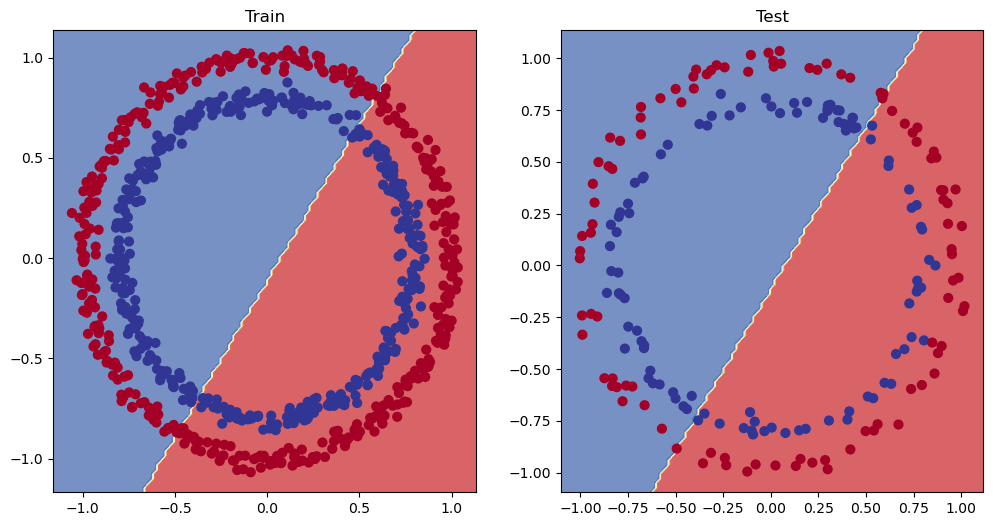

In [23]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective) 

In [24]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))
    
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [25]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(),
                            lr = 0.1)

In [26]:
torch.manual_seed(42)

epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()
    y_logits = model_1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    
    acc = accuracy_fn(y_train, y_pred)
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits,
                            y_test)
        
        test_acc = accuracy_fn(y_test,
                               test_pred)
        
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc}%")

Epoch: 0 | Loss: 0.69396, Accuracy: 49.50% | Test Loss: 0.69261, Test acc: 53.0%
Epoch: 100 | Loss: 0.69305, Accuracy: 49.50% | Test Loss: 0.69379, Test acc: 53.0%
Epoch: 200 | Loss: 0.69298, Accuracy: 49.50% | Test Loss: 0.69437, Test acc: 53.0%
Epoch: 300 | Loss: 0.69298, Accuracy: 49.50% | Test Loss: 0.69458, Test acc: 53.0%
Epoch: 400 | Loss: 0.69298, Accuracy: 49.50% | Test Loss: 0.69465, Test acc: 53.0%
Epoch: 500 | Loss: 0.69298, Accuracy: 49.50% | Test Loss: 0.69467, Test acc: 53.0%
Epoch: 600 | Loss: 0.69298, Accuracy: 49.50% | Test Loss: 0.69468, Test acc: 53.0%
Epoch: 700 | Loss: 0.69298, Accuracy: 49.50% | Test Loss: 0.69468, Test acc: 53.0%
Epoch: 800 | Loss: 0.69298, Accuracy: 49.50% | Test Loss: 0.69468, Test acc: 53.0%
Epoch: 900 | Loss: 0.69298, Accuracy: 49.50% | Test Loss: 0.69468, Test acc: 53.0%


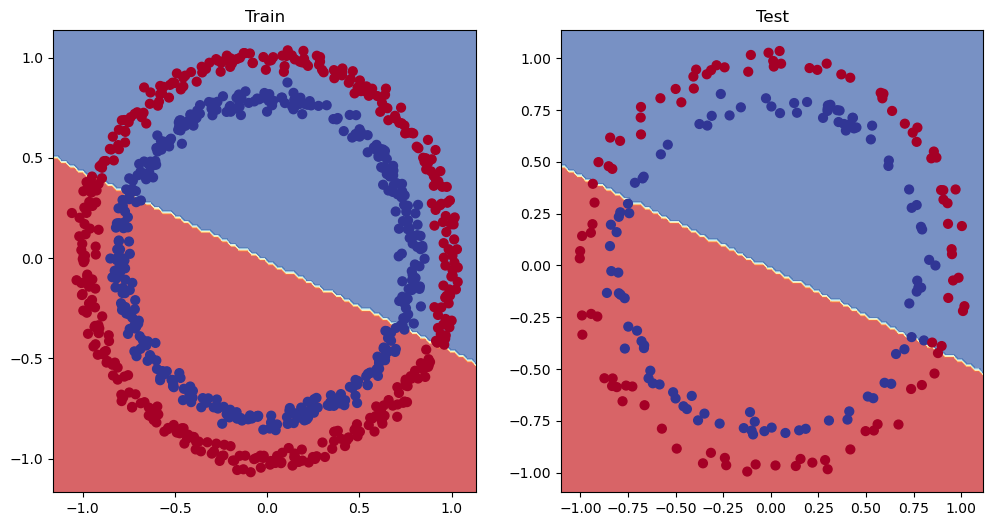

In [27]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## 6. The missing piece: non-linearity 

### 6.1 Recreating non-linear data (red and blue circles)

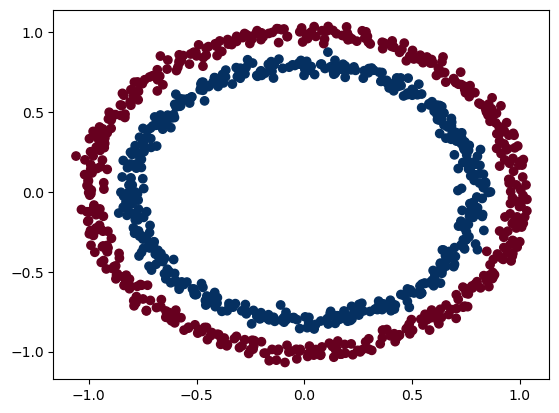

In [47]:
# Make matplotlib.pyplot as plt
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

X, y = make_circles(1000,noise=0.03, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y,  cmap=plt.cm.RdBu)

In [49]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity 

In [53]:
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [54]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr = 0.1)

### 6.3 Training a model with non-linearity

In [56]:
torch.manual_seed(42)

epochs = 1000

X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

for epoch in range(epochs):
    model_3.train()

    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    if epoch%100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.70684, Accuracy: 50.00% | Test Loss: 0.70464, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69301, Accuracy: 49.75% | Test Loss: 0.69122, Test Accuracy: 54.00%
Epoch: 200 | Loss: 0.69129, Accuracy: 50.75% | Test Loss: 0.68961, Test Accuracy: 56.00%
Epoch: 300 | Loss: 0.68996, Accuracy: 51.38% | Test Loss: 0.68847, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68842, Accuracy: 52.50% | Test Loss: 0.68703, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68640, Accuracy: 52.62% | Test Loss: 0.68519, Test Accuracy: 55.50%
Epoch: 600 | Loss: 0.68360, Accuracy: 53.37% | Test Loss: 0.68279, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.67949, Accuracy: 61.88% | Test Loss: 0.67972, Test Accuracy: 61.00%
Epoch: 800 | Loss: 0.67328, Accuracy: 63.88% | Test Loss: 0.67545, Test Accuracy: 58.50%
Epoch: 900 | Loss: 0.66394, Accuracy: 66.88% | Test Loss: 0.66929, Test Accuracy: 61.00%


### 6.4 Evaluating a model trained with non-linear activation functions

In [57]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test).squeeze()))
y_preds[:10], y[:10]

(tensor([1., 0., 0., 0., 1., 1., 0., 0., 0., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

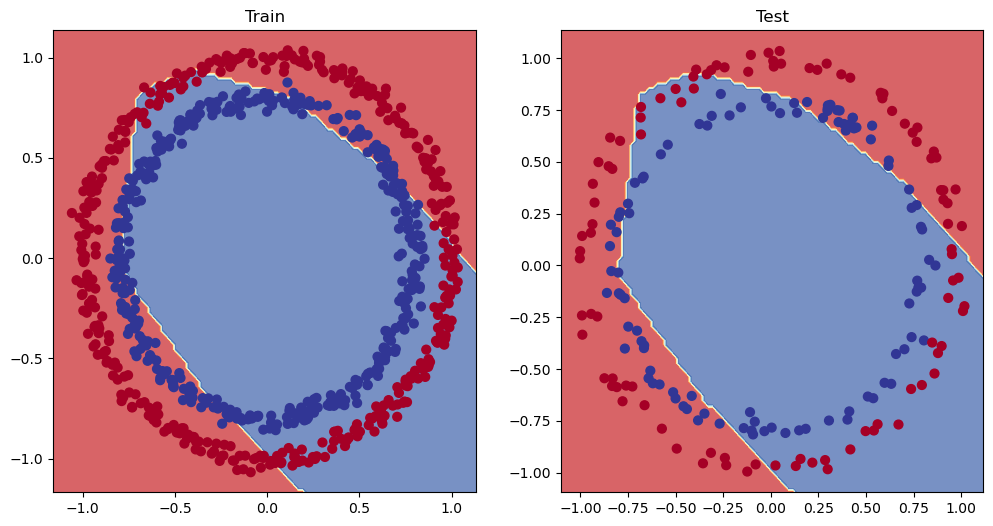

In [58]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non-linear activation functions

In [61]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)

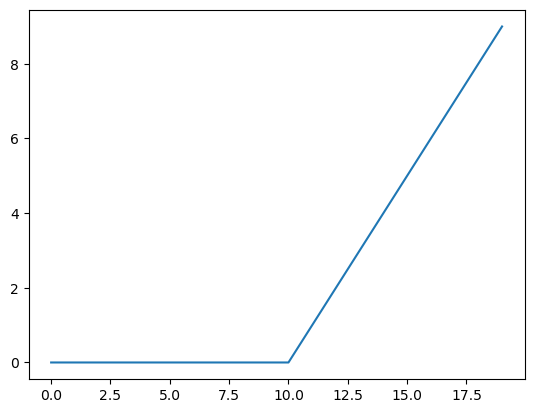

In [62]:
# Create ReLU function by hand 
def relu(x):
  return torch.maximum(torch.tensor(0), x) # inputs must be tensors

# Pass toy tensor through ReLU function
plt.plot(relu(A))

In [63]:
# Create a custom sigmoid function
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

# Test custom sigmoid on toy tensor
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

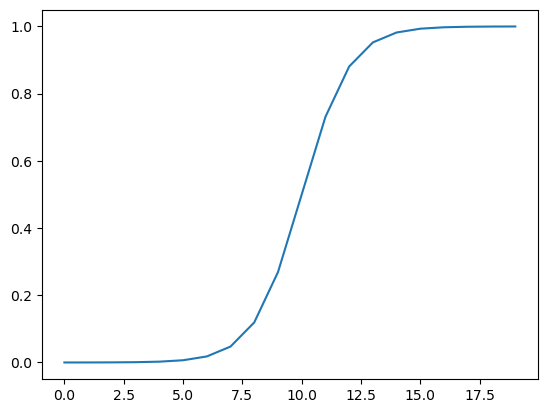

In [64]:
plt.plot(sigmoid(A))

## 8. Putting things together by building a multi-class PyTorch model

### 8.1 Creating multi-class classification data

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


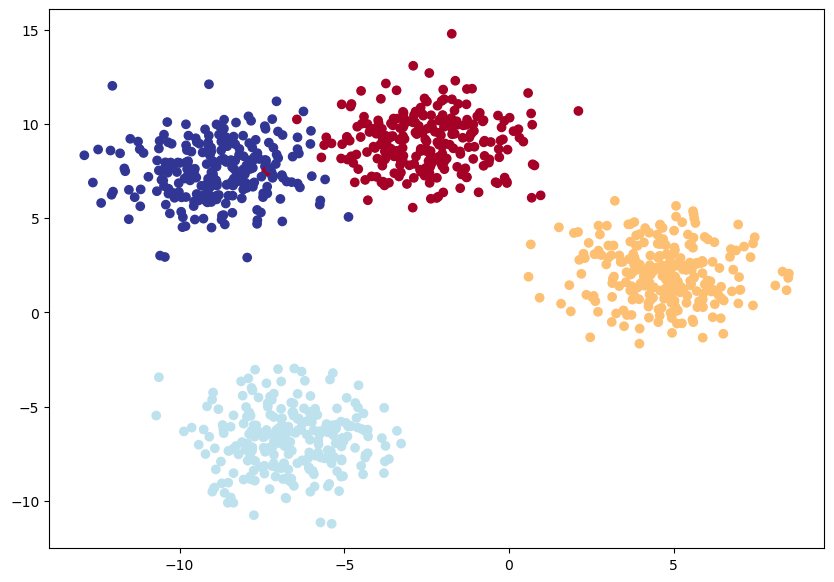

In [66]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

### 8.2 Building a multi-class classification model in PyTorch

In [67]:
from torch import nn

class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)
    
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Creating a loss function and optimizer for a multi-class PyTorch model

In [69]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1)

In [70]:
model_4(X_blob_train.to(device))[:5]

tensor([[-0.7584, -0.6813, -1.5180, -1.1178],
        [-0.2398, -1.2334, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2390, -0.2472,  0.1494,  0.0213],
        [-0.1217, -0.9808, -0.6923, -0.1925]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [71]:
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES 

(torch.Size([4]), 4)

In [72]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7645, -0.7411, -1.5780, -1.1379],
        [-0.0972, -0.9429, -0.5961, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4133, -0.5202, -0.9304, -0.6963],
        [-0.3119, -1.3735, -1.1992, -0.3835]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1287, 0.1532, 0.3463]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [73]:
# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [74]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.3169, 0.3244, 0.1405, 0.2182], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(1, device='cuda:0')


### 8.5 Creating a training and testing loop for a multi-class PyTorch model

In [76]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.15883, Acc: 40.25% | Test Loss: 1.07557, Test Acc: 48.50%
Epoch: 10 | Loss: 0.64478, Acc: 96.75% | Test Loss: 0.66068, Test Acc: 97.50%
Epoch: 20 | Loss: 0.42528, Acc: 98.50% | Test Loss: 0.43076, Test Acc: 100.00%
Epoch: 30 | Loss: 0.25283, Acc: 99.12% | Test Loss: 0.24490, Test Acc: 99.50%
Epoch: 40 | Loss: 0.11222, Acc: 99.25% | Test Loss: 0.10214, Test Acc: 99.50%
Epoch: 50 | Loss: 0.06625, Acc: 99.25% | Test Loss: 0.05850, Test Acc: 99.50%
Epoch: 60 | Loss: 0.05069, Acc: 99.25% | Test Loss: 0.04291, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04299, Acc: 99.25% | Test Loss: 0.03491, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03836, Acc: 99.25% | Test Loss: 0.02984, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03525, Acc: 99.25% | Test Loss: 0.02666, Test Acc: 99.50%


In [77]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[-0.6274,  5.9865, -7.6301, -8.4441],
        [-2.1763, -6.3762, -3.7144,  3.1166],
        [-3.4120, -3.8975,  3.1580, -2.6127],
        [-1.1519,  4.1981, -3.8471, -4.8823],
        [ 3.7544, -1.3327, -9.1398, -6.9474],
        [-2.8235, -7.5815, -4.2950,  3.7947],
        [-3.0331, -3.3353,  2.7979, -2.1384],
        [ 3.3722, -4.0359, -6.8937, -3.5452],
        [-4.3618, -4.9901,  3.8128, -3.3814],
        [ 3.4999, -3.0232, -7.5401, -4.7076]], device='cuda:0')

In [78]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


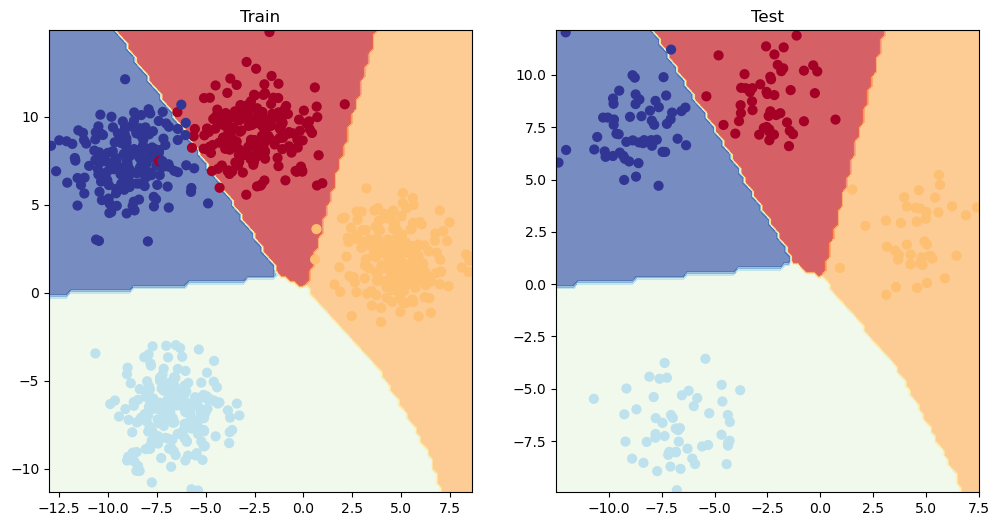

In [79]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)